# Credit Card Customer Attrition Analysis

---
> **Prepared by:** Darius Vincent Ardales
---

## 📋 Business Context
A major bank is experiencing customer churn in its credit card division. Understanding the factors that lead to customer attrition is critical for:
- Designing effective retention strategies
- Improving customer satisfaction

## 🎯 Objective
Build a predictive model to identify customers likely to close their credit card accounts.

## 📊 Dataset Overview
This synthetic dataset contains customer information, transaction history, and demographic details that will help us understand attrition patterns.


## How to Run This Notebook

---

**📋 Prerequisites**

1.  **Python 3.9+**: You can check your Python version by running `python --version` or `python3 --version` in your terminal.
2.  **Dataset**: The `credit_card_attrition_dataset_darius.csv` file must be downloaded and placed in the **same directory** as this notebook.

---

### 🛠️ Setup Instructions

It's highly recommended to use a virtual environment to manage project dependencies and avoid conflicts.

**Step 1: Create and Activate a Virtual Environment**

You can use either `venv` (comes with Python) or `conda` (if you have Anaconda/Miniconda installed). Choose **one** of the options below.

##### Option A: Using `venv`

1.  **Create the environment** (run this in your project directory):
    ```bash
    python3 -m venv venv
    ```

2.  **Activate the environment**:
    * **macOS / Linux**:
        ```bash
        source venv/bin/activate
        ```
    * **Windows (Command Prompt)**:
        ```bash
        .\\venv\\Scripts\\activate
        ```

##### Option B: Using `conda`

1.  **Create the environment**:
    ```bash
    conda create --name credit_attrition python=3.9
    ```

2.  **Activate the environment**:
    ```bash
    conda activate credit_attrition
    ```

**Step 2: Install Required Libraries**

1.  Create a file named `requirements.txt` in the same directory as the notebook.
2.  Copy and paste the following content into the `requirements.txt` file:

    ```
    pandas
    numpy
    matplotlib
    seaborn
    ipython
    scikit-learn
    imbalanced-learn
    lightgbm
    xgboost
    jupyter
    ```

3.  Install all the libraries at once by running the following command in your terminal (make sure your virtual environment is activated!):
    ```bash
    pip install -r requirements.txt
    ```

# 1. Import Required Libraries

In [1]:
# Uncomment if working in Google Colab
# !pip install -q imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import display, Markdown
import os
import joblib
import pickle
from datetime import datetime
import warnings

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTENC

import lightgbm as lgb
import xgboost as xgb

SEED=42
warnings.filterwarnings('ignore', category=RuntimeWarning)

## 2. Load and Explore the Dataset

In [ ]:
# Assuming you placed the dataset in the "datasets" folder
df = pd.read_csv('datasets/credit_card_attrition_dataset_darius.csv')

In [4]:
print(f"Dataset Shape: {df.shape[0]} customers x {df.shape[1]} features")
df.head()

Dataset Shape: 101000 customers x 63 features


,CustomerID,Age,Gender,Income,CreditLimit,TotalTransactions,TotalSpend,Tenure,MaritalStatus,EducationLevel,...,Feature_40,Feature_41,Feature_42,Feature_43,Feature_44,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49
0,CUST047573,45,Female,112955.763499,18089.293599,102,7057.961760,3,Divorced,Master,...,-1.792390,1.157889,1.735477,-0.240003,0.767626,0.242654,0.084097,1.035898,-1.450343,0.083688
1,CUST006615,44,Female,42980.787139,17317.747673,94,8101.572278,9,Divorced,PhD,...,-1.194323,-0.083037,1.142575,1.020381,0.981074,2.002470,-0.847103,0.084373,-0.964711,-0.759402
2,CUST032313,44,Male,114584.549890,17450.444657,87,17989.977994,16,Divorced,Bachelor,...,0.662366,-0.135308,0.606588,-0.207029,-0.913980,0.316399,0.065882,0.253181,-0.262693,-1.645613
3,CUST008756,40,Female,NaN,10444.914691,90,2534.813451,11,Married,Master,...,0.936482,-0.404852,-0.818307,0.559377,-1.227673,-0.066525,1.502226,1.433764,-0.556853,0.227939
4,CUST043700,47,Male,74041.286720,8022.710937,106,6290.093235,4,Single,PhD,...,0.338365,0.646012,-0.102709,0.109845,0.752232,0.810246,-2.212616,-1.198410,0.206907,0.359360


### 2.1 Preliminary Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101000 entries, 0 to 100999
Data columns (total 63 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         101000 non-null  object 
 1   Age                101000 non-null  int64  
 2   Gender             101000 non-null  object 
 3   Income             95945 non-null   float64
 4   CreditLimit        95958 non-null   float64
 5   TotalTransactions  101000 non-null  int64  
 6   TotalSpend         95949 non-null   float64
 7   Tenure             101000 non-null  int64  
 8   MaritalStatus      101000 non-null  object 
 9   EducationLevel     101000 non-null  object 
 10  CardType           101000 non-null  object 
 11  Country            101000 non-null  object 
 12  AttritionFlag      101000 non-null  int64  
 13  Feature_0          101000 non-null  float64
 14  Feature_1          101000 non-null  float64
 15  Feature_2          101000 non-null  float64
 16  Fe

In [6]:
df.describe()

,Age,Income,CreditLimit,TotalTransactions,TotalSpend,Tenure,AttritionFlag,Feature_0,Feature_1,Feature_2,...,Feature_40,Feature_41,Feature_42,Feature_43,Feature_44,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49
count,101000.000000,9.594500e+04,95958.000000,101000.000000,95949.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,...,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000
mean,44.509950,7.625490e+04,14980.997877,99.991386,5201.604187,10.000911,0.049653,0.004445,-0.001509,-0.000433,...,0.003072,-0.003430,-0.005083,0.002089,-0.000044,0.005287,-0.000013,0.002317,-0.004427,-0.000285
std,10.012043,6.825821e+04,5007.463431,9.991337,2976.315536,5.465092,0.217229,1.001087,0.999155,0.999672,...,0.999517,1.002376,1.000198,0.999677,1.001804,0.999114,0.998145,1.001604,1.004311,0.998173
min,0.000000,-1.827772e+04,-7021.069804,61.000000,-4005.132671,1.000000,0.000000,-4.357991,-4.231399,-4.153703,...,-4.113981,-4.849129,-4.486861,-4.342730,-4.395101,-4.312835,-4.304543,-4.361010,-4.287676,-4.279205
25%,38.000000,5.665176e+04,11613.898089,93.000000,3663.273783,5.000000,0.000000,-0.672617,-0.674875,-0.670246,...,-0.670877,-0.673067,-0.679959,-0.670084,-0.674954,-0.668517,-0.675626,-0.676420,-0.683136,-0.673436
50%,45.000000,7.027228e+04,14963.494610,100.000000,5029.493748,10.000000,0.000000,0.003476,-0.005582,0.000868,...,0.000659,-0.005786,-0.006709,0.001274,-0.000748,0.008122,-0.000509,0.003317,-0.003529,-0.000770
75%,51.000000,8.397986e+04,18341.161845,107.000000,6398.315669,15.000000,0.000000,0.675426,0.676809,0.674518,...,0.674418,0.668481,0.671037,0.677454,0.679458,0.677500,0.671088,0.676976,0.675218,0.671510
max,89.000000,1.233744e+06,36096.831719,146.000000,53896.734185,19.000000,1.000000,4.441448,4.381350,4.253646,...,4.338037,4.113717,4.101093,4.357028,4.522098,4.394473,4.278007,4.270151,4.301758,4.890074


#### Preliminary Insights

1. **Class Imbalance**: The **AttritionFlag** has a mean of ~0.05, indicating only about **5% customer attrition rate**, representing a significantly imbalanced dataset that will require careful handling during modeling.

2. **Standardized Anonymous Features**: All 50 anonymous features (**Feature_0** through **Feature_49**) appear to be **pre-processed and standardized**, with means hovering near 0 (ranging from -0.005 to 0.005) and standard deviations very close to 1, suggesting these features have already undergone normalization or standardization.

3. **Missing Data**: Business features show missing values - **Income**, **CreditLimit**, and **TotalSpend** which indicates these customers have incomplete financial profiles.

4. **Feature Scale Disparities**: Business features exhibit vastly different scales - **Age** ranges 0-89, **Income** reaches 123k+, **CreditLimit** extends to 36k+, while **TotalTransactions** spans 61-146, necessitating feature scaling for distance-based algorithms.

5. **Anomalous Negative Values**: **CreditLimit** show a negative minimum value, which could represent data quality issues, special account statuses, or encoding for specific business conditions that warrant investigation.

### 2.2 Feature Types

In [7]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical Features: {len(numerical_cols)}")
print(f"Categorical Features: {len(categorical_cols)}")

Numerical Features: 57
Categorical Features: 6


The dataset contains a comprehensive set of features that can be categorized into distinct groups. First, we have **CustomerID** serving as the unique identifier key, which is of object type (categorical).

The core of the dataset consists of **11 Business Features** that represent known customer attributes: **Age** (int64), **Gender** (object), **Income** (float64), **CreditLimit** (float64), **TotalTransactions** (int64), **TotalSpend** (float64), **Tenure** (int64), **MaritalStatus** (object), **EducationLevel** (object), **CardType** (object), and **Country** (object). These features provide interpretable business insights about customer demographics, financial behavior, and account characteristics.

Additionally, the dataset includes **50 Anonymous Features** labeled from **Feature_0** through **Feature_49**, all of which are float64 type. These encoded features likely represent proprietary or sensitive information that has been anonymized for privacy or competitive reasons.

The dataset appears to be designed for a classification task, with **AttritionFlag** serving as the target variable, indicating customer churn or retention status.

In terms of data type distribution, the dataset comprises **57 Numerical Features** (including the anonymous features, income, credit limit, total spend, age, total transactions, and tenure) and **6 Categorical Features** (customer ID, gender, marital status, education level, card type, and country), providing a rich mix of quantitative and qualitative information for analysis.

### 2.3 Business (Known) Features

- **Numerical**: Age, Income, CreditLimit, TotalTransactions, TotalSpend, Tenure
- **Categorical**: Gender, MaritalStatus, EducationLevel, CardType, Country
- **Target (Binary)**: AttritionFlag
  - 0 = No Attrition (Customer retained)
  - 1 = Attrition (Customer closed credit card)

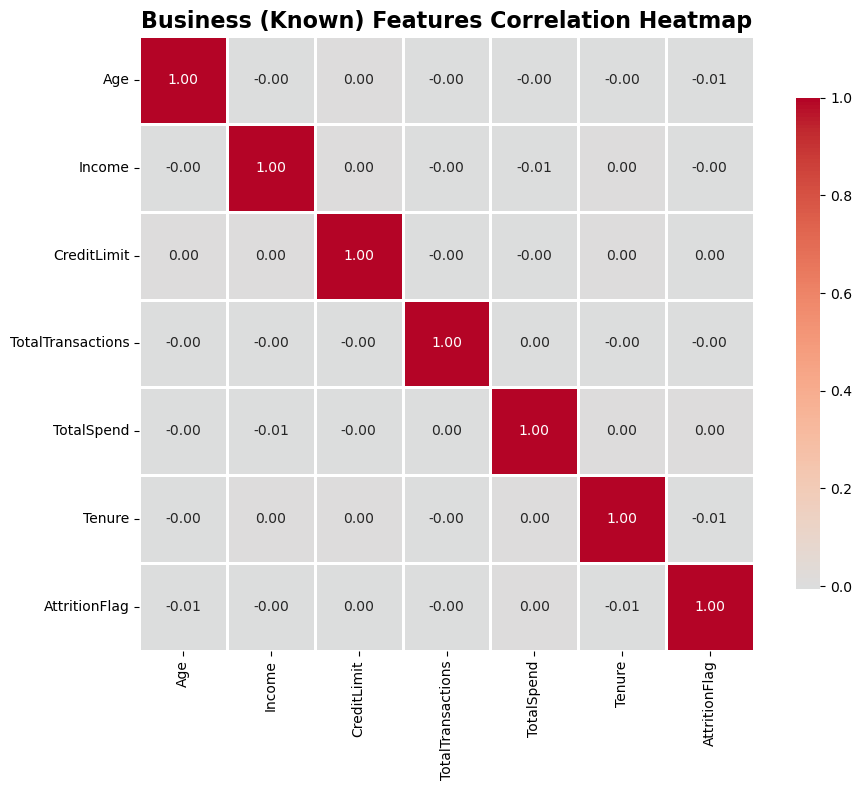

In [8]:
business_numerical = ['Age', 'Income', 'CreditLimit', 'TotalTransactions', 'TotalSpend', 'Tenure', 'AttritionFlag']
business_corr = df[business_numerical].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(business_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Business (Known) Features Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

The correlation heatmap reveals that the numerical business features exhibit **weak to negligible correlations** with one another, indicating that these variables capture largely independent aspects of customer behavior. Most notably, **AttritionFlag** shows minimal correlation with all other business features, suggesting that customer churn is not strongly linearly associated with any single numerical attribute such as age, income, credit limit, or transaction patterns. This lack of strong linear relationships implies that predicting attrition may require more complex modeling approaches or consideration of feature interactions and non-linear patterns.

### 2.4 Anonymous Features
- Note that we're only selecting the first 15 features to represent the anonymous features and to not make the heatmap too large

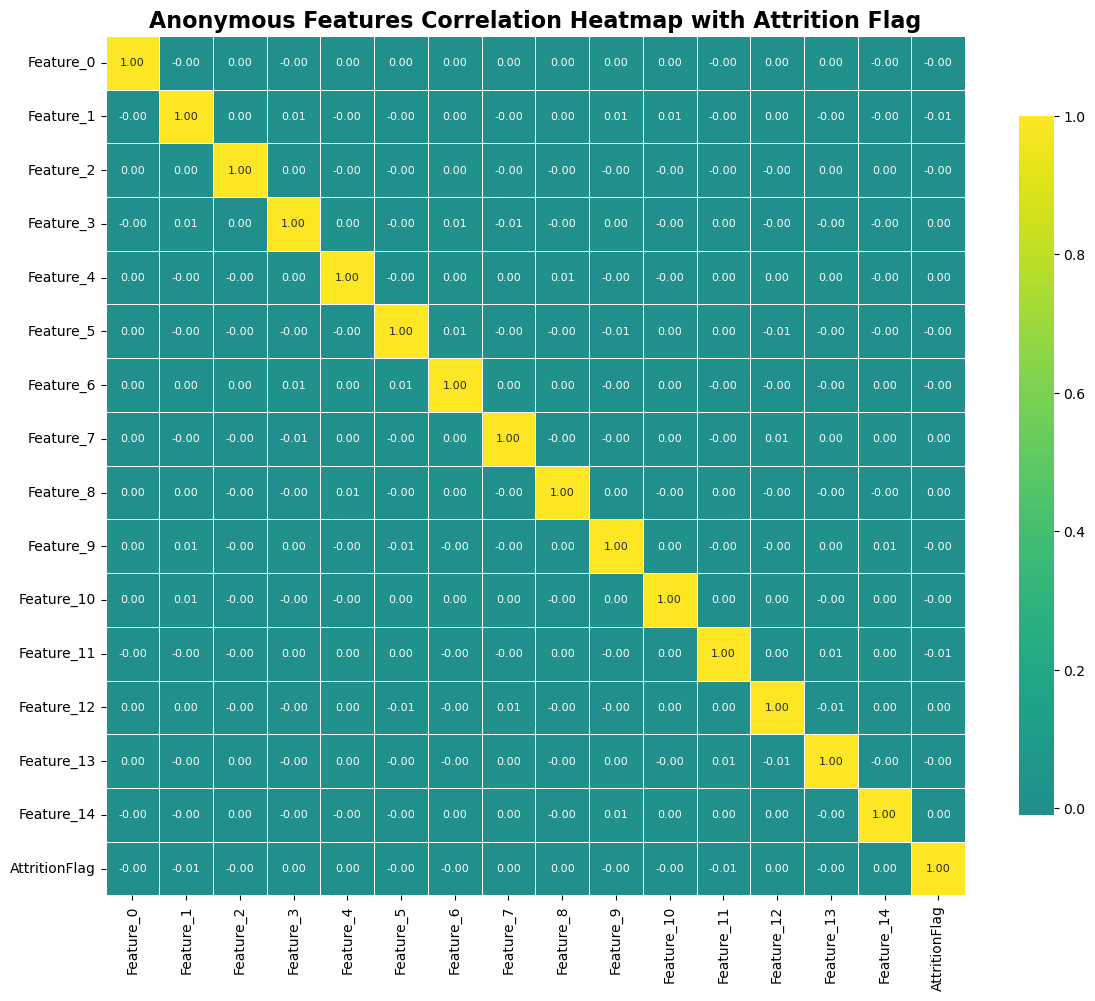

In [9]:
non_business_sample = [f'Feature_{i}' for i in range(15)] + ['AttritionFlag']
non_business_corr = df[non_business_sample].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(non_business_corr, annot=True, cmap='viridis', center=0, fmt='.2f',
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, annot_kws={'size': 8})
plt.title('Anonymous Features Correlation Heatmap with Attrition Flag', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Same as the business features:

1. **Complete Feature Independence**: All anonymous features exhibit **near-zero correlations** with each other (all values ≤ |0.01|), indicating these features are **perfectly orthogonal or independent**.

2. **No Linear Predictive Power for Attrition**: The **AttritionFlag** row shows correlations ranging from -0.01 to 0.01 with all anonymous features, meaning **none of these engineered features have individual linear relationships** with customer churn.

# 3. Data Cleaning

This section systematically cleans and prepares the data for modeling by addressing:
- Duplicate records identification and removal  
- Outlier detection
- Missing values analysis and imputation
- Data integrity checks
- Class imbalance assessment

In [10]:
df_clean = df.copy()

### 3.1 Duplicate Records

In [11]:
total_duplicates = df_clean.duplicated().sum()
print(f"Total duplicate rows: {total_duplicates}")

Total duplicate rows: 1000


In [12]:
# Remove duplicate rows, keeping the first occurrence
df_clean = df_clean.drop_duplicates(keep='first')

print(f"Original shape: {df.shape}")
print(f"New shape: {df_clean.shape}")
print(f"Rows removed: {len(df) - len(df_clean)}")

Original shape: (101000, 63)
New shape: (100000, 63)
Rows removed: 1000


In [13]:
total_duplicates = df_clean.duplicated().sum()
print(f"Total duplicate rows: {total_duplicates}")

Total duplicate rows: 0


### 3.2 Problematic Features

#### 3.2.1 Age Limit (below 7 years old)
- Source: [First Savings](https://www.unionbankph.com/accounts/first-savings)


In [14]:
age_issues = df_clean[df_clean['Age'] < 7]
print(f"Records with Age < 7: {len(age_issues)}")

print("\nAge distribution for problematic records:")
pd.DataFrame(age_issues['Age'].value_counts().sort_index())

Records with Age < 7: 9

Age distribution for problematic records:


,count
Age,
0,2
2,1
3,1
5,2
6,3


In [15]:
# Remove rows with Age < 7 from df_clean
df_clean = df_clean[(df_clean['Age'] >= 7) | (df_clean['Age'].isnull())]
print(f"Rows remaining after removing Age < 7: {len(df_clean)}")

Rows remaining after removing Age < 7: 99991


#### 3.2.2 Negative Income

In [16]:
negative_income = df_clean[df_clean['Income'] < 0]
print(f"Records with negative Income: {len(negative_income)}")

print(f"\nNegative Income range: [{negative_income['Income'].min():,.2f}, {negative_income['Income'].max():,.2f}]")

Records with negative Income: 23

Negative Income range: [-18,277.72, -82.79]


> Decision: No Action. Income can be negative, which signifies a loss rather than a profit.

#### 3.2.3 Check Negative Credit Limit

In [17]:
negative_credit = df_clean[df_clean['CreditLimit'] < 0]
null_credit = df_clean['CreditLimit'].isnull().sum()

print(f"Records with negative CreditLimit: {len(negative_credit)}")
print(f"Records with NULL CreditLimit: {null_credit}")
print(f"\nNegative CreditLimit range: [{negative_credit['CreditLimit'].min():,.2f}, {negative_credit['CreditLimit'].max():,.2f}]")
print(f"\nNote: NULL values will be preserved and imputed later")

Records with negative CreditLimit: 142
Records with NULL CreditLimit: 5000

Negative CreditLimit range: [-7,021.07, -2.40]

Note: NULL values will be preserved and imputed later


In [18]:
df_clean = df_clean[(df_clean['CreditLimit'] >= 0) | (df_clean['CreditLimit'].isnull())]
print(f"Rows remaining after removing negative CreditLimit: {len(df_clean)}")

Rows remaining after removing negative CreditLimit: 99849


#### 3.2.4 Negative Total Spend (might be refunds)

In [19]:
negative_spend = df_clean[df_clean['TotalSpend'] < 0]
print(f"Records with negative TotalSpend: {len(negative_spend)}")

print(f"\nNegative TotalSpend range: [{negative_spend['TotalSpend'].min():,.2f}, {negative_spend['TotalSpend'].max():,.2f}]")

Records with negative TotalSpend: 577

Negative TotalSpend range: [-4,005.13, -1.36]


> Decision: No Action. Negative Total Spendings might be refunds.

### 3.3 Outliers

The **Interquartile Range (IQR)** method was chosen for outlier detection because:
- **Non-parametric**: Doesn't assume normal distribution, suitable for skewed financial data
- **Business-friendly**: The 1.5×IQR threshold is an industry standard that identifies truly unusual values
- **Interpretable**: Easy to explain to stakeholders (values beyond 1.5 times the middle 50% range)

In [20]:
def detect_outliers_iqr(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

#### 3.3.1 Business Features

In [21]:
business_cols = ['Age', 'Income', 'CreditLimit', 'TotalTransactions', 'TotalSpend', 'Tenure'] # Exclude 'AttritionFlag'

outlier_summary = []
for col in business_cols:
    outliers, lower, upper = detect_outliers_iqr(df_clean, col)
    outlier_pct = (len(outliers) / len(df_clean)) * 100

    outlier_summary.append({
        'Feature': col,
        'Outliers': len(outliers),
        'Percentage': f"{outlier_pct:.2f}%",
        'Lower_Bound': f"{lower:,.2f}",
        'Upper_Bound': f"{upper:,.2f}"
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df

,Feature,Outliers,Percentage,Lower_Bound,Upper_Bound
0,Age,927,0.93%,18.50,70.50
1,Income,1509,1.51%,"15,640.87","124,988.64"
2,CreditLimit,587,0.59%,"1,555.49","28,424.14"
3,TotalTransactions,474,0.47%,72.00,128.00
4,TotalSpend,1479,1.48%,-441.40,"10,500.42"
5,Tenure,0,0.00%,-10.00,30.00


The analysis reveals **minimal outliers across all features**:
- **TotalSpend** (1.48%) and **Income** (1.51%): Highest outlier rates, likely representing premium customers
- **Age** (0.93%): Few outliers, possibly very young or senior customers
- **CreditLimit** (0.59%) and **TotalTransactions** (0.47%): Very few extreme values
- **Tenure** (0%): No outliers detected, indicating consistent customer tenure patterns

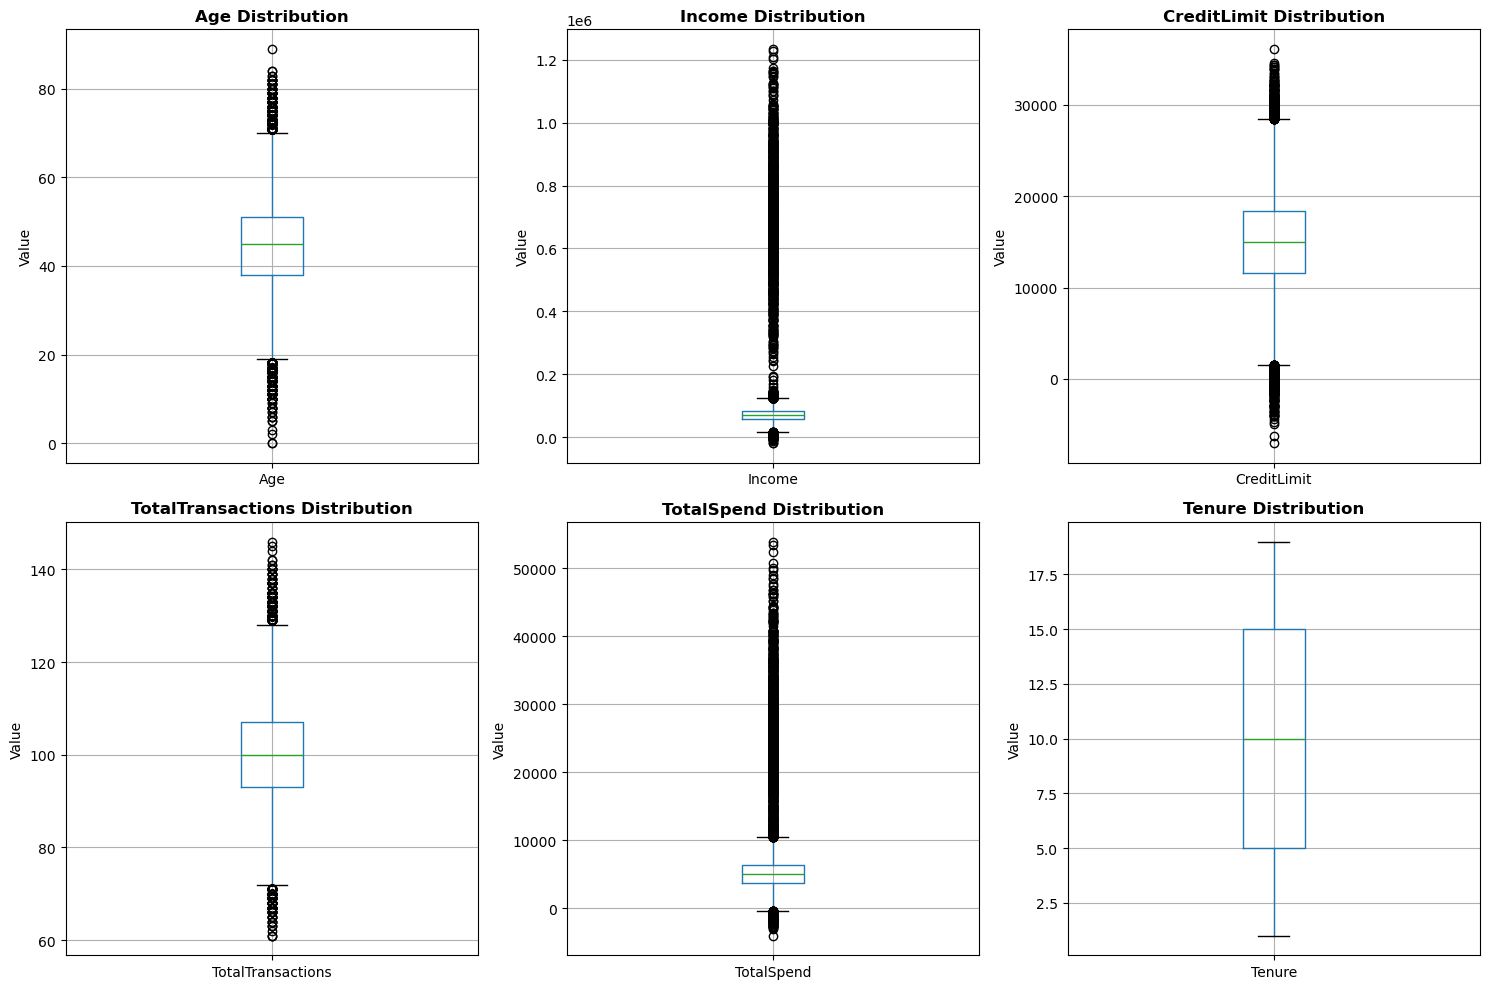

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(business_cols):
    # Box plot
    df.boxplot(column=col, ax=axes[idx])
    axes[idx].set_title(f'{col} Distribution', fontweight='bold')
    axes[idx].set_ylabel('Value')

plt.tight_layout()
plt.show()

> Decision: Retain All Outliers for Business Features

for the following reasons:

1. **Low percentages**: All features have <2% outliers, indicating these are rare but legitimate cases
2. **Business value**: These outliers likely represent important customer segments (high-value customers, edge demographics)
3. **Predictive importance**: Extreme behaviors might be strong indicators of attrition patterns
4. **Statistical validity**: Removing only 1-2% of data won't significantly impact model robustness
5. **Risk of information loss**: Removing outliers could eliminate critical patterns for predicting customer churn

Rather than removing valuable data points, we'll let our models learn from the full customer spectrum.

#### 3.3.2 Anonymous Features

In [23]:
anonymous_features = [f'Feature_{i}' for i in range(50)]

features_with_outliers = []
for col in anonymous_features:
    outliers, lower, upper = detect_outliers_iqr(df_clean, col)
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df_clean)) * 100

    # Only report features with outliers
    if outlier_count > 0:
        features_with_outliers.append({
            'Feature': col,
            'Outliers': outlier_count,
            'Percentage': f"{outlier_pct:.2f}%",
            'Lower_Bound': f"{lower:.3f}",
            'Upper_Bound': f"{upper:.3f}"
        })

print(f"Features with outliers: {len(features_with_outliers)} / {len(anonymous_features)}")
features_with_outliers_df = pd.DataFrame(features_with_outliers)
features_with_outliers_df.head(10)

Features with outliers: 50 / 50


,Feature,Outliers,Percentage,Lower_Bound,Upper_Bound
0,Feature_0,720,0.72%,-2.694,2.696
1,Feature_1,657,0.66%,-2.702,2.705
2,Feature_2,720,0.72%,-2.687,2.692
3,Feature_3,699,0.70%,-2.708,2.700
4,Feature_4,707,0.71%,-2.701,2.707
5,Feature_5,690,0.69%,-2.685,2.693
6,Feature_6,658,0.66%,-2.702,2.701
7,Feature_7,712,0.71%,-2.708,2.706
8,Feature_8,718,0.72%,-2.691,2.691
9,Feature_9,761,0.76%,-2.690,2.699


In [24]:
pct_values = features_with_outliers_df['Percentage'].str.rstrip('%').astype(float)
lower_bounds = features_with_outliers_df['Lower_Bound'].astype(float)
upper_bounds = features_with_outliers_df['Upper_Bound'].astype(float)

print(f"Outlier percentage range: {pct_values.min():.2f}% - {pct_values.max():.2f}%")
print(f"Bound range: [{lower_bounds.min():.3f}, {upper_bounds.max():.3f}]")

Outlier percentage range: 0.64% - 0.77%
Bound range: [-2.720, 2.722]


> Decision: Retain All Outliers for Anonymous Features

for the following reasons:

1. **Outlier rates**: Extremely consistent at 0.64% - 0.77%
2. **Bounds**: Uniform at approximately ±2.7 for all features
3. **Already Standardized**: The ±2.7 bounds correspond to ~2.7 standard deviations, confirming these features are pre-standardized (mean=0, std=1)
4. **Minimal Impact**: Less than 0.8% outliers per feature means removing them would affect <1% of the dataset
5. **Consistent Distribution**: The uniformity indicates these outliers are part of the designed feature distribution, not errors

These outliers are **features, not bugs**. They represent the natural tails of engineered distributions and should be preserved to maintain the integrity of the anonymous feature space.

### 3.4 Missing Values

#### 3.4.1 Finding Missing Values

In [25]:
rows_with_null = df_clean.isnull().any(axis=1).sum()
percent_rows_with_null = (rows_with_null / len(df_clean)) * 100
print(f"Total rows with at least one null value: {rows_with_null} / {len(df_clean)}")
print(f"Total percentage of rows with at least one null value: {percent_rows_with_null:.2f}%")

Total rows with at least one null value: 14224 / 99849
Total percentage of rows with at least one null value: 14.25%


In [26]:
missing_values = df_clean.isnull().sum()
missing_percent = (missing_values / len(df_clean)) * 100

missing_summary = pd.DataFrame({
    'Missing_Count': missing_values[missing_values > 0],
    'Missing_Percentage': missing_percent[missing_values > 0].round(3)
}).sort_values('Missing_Percentage', ascending=False)

missing_summary.head()

,Missing_Count,Missing_Percentage
CreditLimit,5000,5.008
TotalSpend,4991,4.999
Income,4989,4.997


<Figure size 800x500 with 0 Axes>

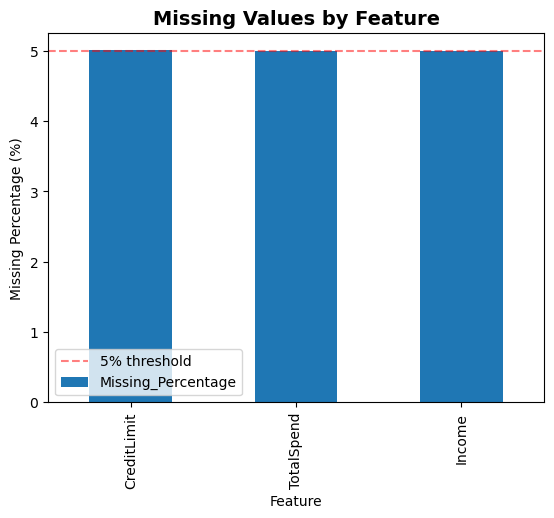

In [27]:
plt.figure(figsize=(8, 5))

missing_summary.plot(kind='bar', y='Missing_Percentage', legend=False)
plt.title('Missing Values by Feature', fontsize=14, fontweight='bold')
plt.xlabel('Feature')
plt.ylabel('Missing Percentage (%)')
plt.axhline(y=5, color='r', linestyle='--', alpha=0.5, label='5% threshold')

plt.legend()
plt.show()

#### 3.4.2 Deeper Dive to Missing Income, TotalSpend, and CreditLimit

In [28]:
missing_pattern = df_clean[['Income', 'TotalSpend', 'CreditLimit']].isnull()

# All combinations
all_missing = (missing_pattern['Income'] & missing_pattern['TotalSpend'] & missing_pattern['CreditLimit']).sum()
income_spend_only = (missing_pattern['Income'] & missing_pattern['TotalSpend'] & ~missing_pattern['CreditLimit']).sum()
income_credit_only = (missing_pattern['Income'] & ~missing_pattern['TotalSpend'] & missing_pattern['CreditLimit']).sum()
spend_credit_only = (~missing_pattern['Income'] & missing_pattern['TotalSpend'] & missing_pattern['CreditLimit']).sum()
income_only = (missing_pattern['Income'] & ~missing_pattern['TotalSpend'] & ~missing_pattern['CreditLimit']).sum()
spend_only = (~missing_pattern['Income'] & missing_pattern['TotalSpend'] & ~missing_pattern['CreditLimit']).sum()
credit_only = (~missing_pattern['Income'] & ~missing_pattern['TotalSpend'] & missing_pattern['CreditLimit']).sum()

print(f"All three missing: {all_missing} rows")
print(f"Income & TotalSpend missing: {income_spend_only} rows")
print(f"Income & CreditLimit missing: {income_credit_only} rows")
print(f"TotalSpend & CreditLimit missing: {spend_credit_only} rows")
print(f"Only Income missing: {income_only} rows")
print(f"Only TotalSpend missing: {spend_only} rows")
print(f"Only CreditLimit missing: {credit_only} rows")

print(f"\nCorrelation matrix between missing patterns:")
print(missing_pattern.corr().round(3))

All three missing: 13 rows
Income & TotalSpend missing: 262 rows
Income & CreditLimit missing: 235 rows
TotalSpend & CreditLimit missing: 233 rows
Only Income missing: 4479 rows
Only TotalSpend missing: 4483 rows
Only CreditLimit missing: 4519 rows

Correlation matrix between missing patterns:
             Income  TotalSpend  CreditLimit
Income        1.000       0.005       -0.000
TotalSpend    0.005       1.000       -0.001
CreditLimit  -0.000      -0.001        1.000


#### 3.4.3 Check Distributions

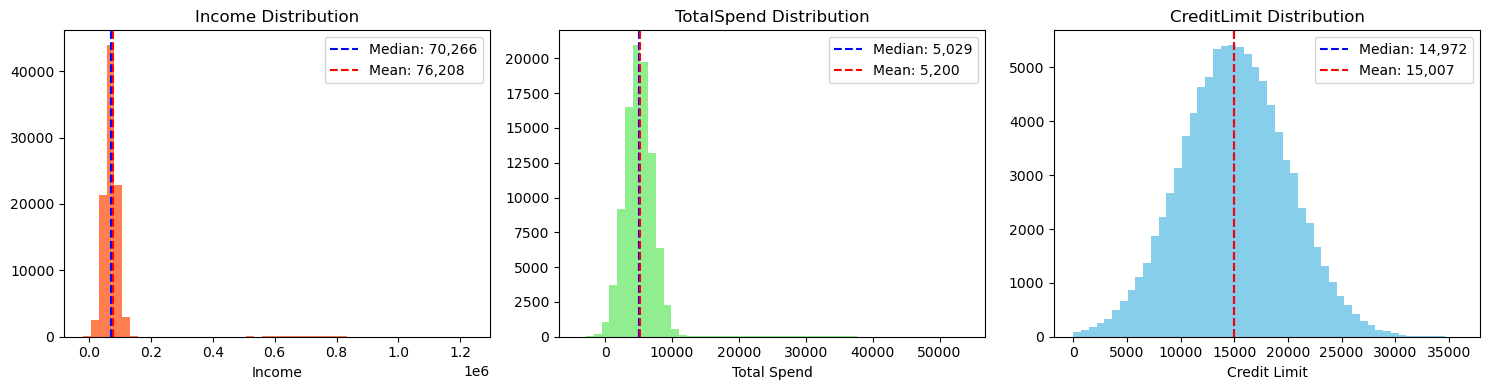

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Income distribution
axes[0].hist(df_clean['Income'].dropna(), bins=50, color='coral')
axes[0].axvline(df_clean['Income'].median(), color='blue', linestyle='--', label=f'Median: {df_clean["Income"].median():,.0f}')
axes[0].axvline(df_clean['Income'].mean(), color='red', linestyle='--', label=f'Mean: {df_clean["Income"].mean():,.0f}')
axes[0].set_title('Income Distribution')
axes[0].set_xlabel('Income')
axes[0].legend()

# TotalSpend distribution
axes[1].hist(df_clean['TotalSpend'].dropna(), bins=50, color='lightgreen')
axes[1].axvline(df_clean['TotalSpend'].median(), color='blue', linestyle='--', label=f'Median: {df_clean["TotalSpend"].median():,.0f}')
axes[1].axvline(df_clean['TotalSpend'].mean(), color='red', linestyle='--', label=f'Mean: {df_clean["TotalSpend"].mean():,.0f}')
axes[1].set_title('TotalSpend Distribution')
axes[1].set_xlabel('Total Spend')
axes[1].legend()

# CreditLimit distribution
axes[2].hist(df_clean['CreditLimit'].dropna(), bins=50, color='skyblue')
axes[2].axvline(df_clean['CreditLimit'].median(), color='blue', linestyle='--', label=f'Median: {df_clean["CreditLimit"].median():,.0f}')
axes[2].axvline(df_clean['CreditLimit'].mean(), color='red', linestyle='--', label=f'Mean: {df_clean["CreditLimit"].mean():,.0f}')
axes[2].set_title('CreditLimit Distribution')
axes[2].set_xlabel('Credit Limit')
axes[2].legend()

plt.tight_layout()
plt.show()

#### 3.4.4 Apply Mean Imputation
- Missing values per feature is <= to 5%
- Independent missing patterns (correlation <= 0.005) tells us we can use simple imputation rather than advanced methods
- The distributions are normal (mean is best for normal data)

In [30]:
income_mean = df_clean['Income'].mean()
spend_mean = df_clean['TotalSpend'].mean()
credit_mean = df_clean['CreditLimit'].mean()

df_clean['Income'] = df_clean['Income'].fillna(income_mean)
df_clean['TotalSpend'] = df_clean['TotalSpend'].fillna(spend_mean)
df_clean['CreditLimit'] = df_clean['CreditLimit'].fillna(credit_mean)

print(f"Income: Imputed missing values with mean {income_mean:,.2f}")
print(f"TotalSpend: Imputed missing values with mean {spend_mean:,.2f}")
print(f"CreditLimit: Imputed missing values with mean {credit_mean:,.2f}")

Income: Imputed missing values with mean 76,207.87
TotalSpend: Imputed missing values with mean 5,199.93
CreditLimit: Imputed missing values with mean 15,006.67


In [31]:
num_features_with_nulls = (df_clean.isnull().sum() > 0).sum()
print(f"Number of features with nulls: {num_features_with_nulls}")

Number of features with nulls: 0


### 3.5 Cardinality of Categorical Features

#### 3.5.1 Finding Features with High Cardinality

In [32]:
categorical_features = ['Gender', 'MaritalStatus', 'EducationLevel', 'CardType', 'Country']

cardinality_analysis = []
for col in categorical_features:
    unique_values = df_clean[col].nunique()
    cardinality_analysis.append({
        'Feature': col,
        'Unique_Values': unique_values,
    })

cardinality_df = pd.DataFrame(cardinality_analysis)
cardinality_df

,Feature,Unique_Values
0,Gender,2
1,MaritalStatus,4
2,EducationLevel,4
3,CardType,4
4,Country,100


In [33]:
unique_countries = df_clean['Country'].unique()
print("Sample countries:", ', '.join(unique_countries[:10]),)
print("Last country:", unique_countries[-1])

Sample countries: Country_36, Country_97, Country_34, Country_54, Country_2, Country_26, Country_55, Country_47, Country_41, Country_70
Last country: Country_37


#### 3.5.2 Treating the Cardinality of the Country Feature

In [34]:
country_counts = df_clean['Country'].value_counts()
print(f"Total unique countries: {df_clean['Country'].nunique()}")
print(f"Max customers per country: {country_counts.max()}")
print(f"Min customers per country: {country_counts.min()}")
print(f"Mean customers per country: {country_counts.mean():.0f}")
print(f"Std deviation: {country_counts.std():.0f}")

Total unique countries: 100
Max customers per country: 1072
Min customers per country: 924
Mean customers per country: 998
Std deviation: 33


In [35]:
# Calculate attrition rate by country
country_attrition = df_clean.groupby('Country')['AttritionFlag'].mean()
print(f"Attrition rate range: {country_attrition.min():.3f} to {country_attrition.max():.3f}")
print(f"Attrition rate variance across countries: {country_attrition.var():.5f}")
print(f"Overall attrition rate: {df_clean['AttritionFlag'].mean():.3f}")

Attrition rate range: 0.033 to 0.067
Attrition rate variance across countries: 0.00005
Overall attrition rate: 0.050


- **Distribution:** All 100 countries have 924-1024 customers (uniform)
- **Attrition Impact:** Variance of 0.00005 (negligible)

> Decision: DROP the Country feature

Reasons:
1. No predictive value for attrition
2. Would create 100 dummy variables
3. Risk of overfitting without benefit

#### 3.5.3 Drop Country Feature

In [36]:
df_clean = df_clean.drop(columns=['Country'])
print(f"Country feature dropped")
print(f"Remaining features: {df_clean.shape[1]}")
print(f"Remaining categorical features: {['Gender', 'MaritalStatus', 'EducationLevel', 'CardType']}")

Country feature dropped
Remaining features: 62
Remaining categorical features: ['Gender', 'MaritalStatus', 'EducationLevel', 'CardType']


### 3.6 Imbalanced Features

In [37]:
numerical_cols = ['Age', 'Income', 'CreditLimit', 'TotalTransactions', 'TotalSpend', 'Tenure'] + \
                 [col for col in df_clean.columns if col.startswith('Feature_')]
categorical_cols = ['Gender', 'MaritalStatus', 'EducationLevel', 'CardType']

print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

Numerical features: 56
Categorical features: 4


#### 3.6.1 Checking Categorical Variables

In [38]:
markdown_output = "**Categorical Variables Distribution**\n\n"

for col in categorical_cols:
    # Get value counts and percentages
    value_counts = df_clean[col].value_counts()
    value_pcts = df_clean[col].value_counts(normalize=True) * 100

    # Calculate imbalance ratio
    max_count = value_counts.max()
    min_count = value_counts.min()
    imbalance_ratio = max_count / min_count

    # Determine balance status
    status = "⚠️ IMBALANCED" if imbalance_ratio > 3 else "✓ Balanced"

    # Build table for this variable
    markdown_output += f"**{col}** - {status} (Ratio: {imbalance_ratio:.1f}:1)\n\n"
    markdown_output += "| Value | Count | Percentage |\n"
    markdown_output += "|:------|------:|----------:|\n"

    for value in value_counts.index:
        markdown_output += f"| {value} | {value_counts[value]:,} | {value_pcts[value]:.0f}% |\n"

    markdown_output += "\n"

display(Markdown(markdown_output))

**Categorical Variables Distribution**

**Gender** - ✓ Balanced (Ratio: 1.0:1)

| Value | Count | Percentage |
|:------|------:|----------:|
| Female | 50,115 | 50% |
| Male | 49,734 | 50% |

**MaritalStatus** - ✓ Balanced (Ratio: 1.0:1)

| Value | Count | Percentage |
|:------|------:|----------:|
| Divorced | 25,159 | 25% |
| Married | 25,086 | 25% |
| Widowed | 24,911 | 25% |
| Single | 24,693 | 25% |

**EducationLevel** - ✓ Balanced (Ratio: 1.0:1)

| Value | Count | Percentage |
|:------|------:|----------:|
| Master | 25,037 | 25% |
| High School | 24,998 | 25% |
| Bachelor | 24,945 | 25% |
| PhD | 24,869 | 25% |

**CardType** - ✓ Balanced (Ratio: 1.0:1)

| Value | Count | Percentage |
|:------|------:|----------:|
| Platinum | 25,061 | 25% |
| Black | 25,039 | 25% |
| Gold | 24,961 | 25% |
| Silver | 24,788 | 25% |



#### 3.6.2 Target Variable `AttritionFlag`

In [39]:
attrition_counts = df_clean['AttritionFlag'].value_counts()
attrition_pct = df_clean['AttritionFlag'].value_counts(normalize=True) * 100

display(Markdown(f"""
**Target Variable Distribution:**

No Attrition (0): **{attrition_counts[0]:,}** ({attrition_pct[0]:.1f}%)
Attrition (1): **{attrition_counts[1]:,}** ({attrition_pct[1]:.1f}%)

**Imbalance:** {attrition_counts[0]/attrition_counts[1]:.0f}:1 ratio with {attrition_pct[1]:.1f}% minority class
"""))


**Target Variable Distribution:**

No Attrition (0): **94,897** (95.0%)
Attrition (1): **4,952** (5.0%)

**Imbalance:** 19:1 ratio with 5.0% minority class


In [40]:
X = df_clean.drop(columns=['AttritionFlag', 'CustomerID'])
y = df_clean['AttritionFlag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

train_dist = y_train.value_counts(normalize=True) * 100
test_dist = y_test.value_counts(normalize=True) * 100

display(Markdown(f"""
**Train-Test Split Summary**

| Dataset | Samples | Features | Class 0 | Class 1 |
|:--------|--------:|---------:|--------:|--------:|
| Training | {X_train.shape[0]:,} | {X_train.shape[1]} | {train_dist[0]:.1f}% | {train_dist[1]:.1f}% |
| Test | {X_test.shape[0]:,} | {X_test.shape[1]} | {test_dist[0]:.1f}% | {test_dist[1]:.1f}% |

**Split Configuration:** 80/20 split with stratification to maintain class distribution
"""))


**Train-Test Split Summary**

| Dataset | Samples | Features | Class 0 | Class 1 |
|:--------|--------:|---------:|--------:|--------:|
| Training | 79,879 | 60 | 95.0% | 5.0% |
| Test | 19,970 | 60 | 95.0% | 5.0% |

**Split Configuration:** 80/20 split with stratification to maintain class distribution


#### 3.6.3 Using Synthetic Minority Over-sampling Technique (SMOTE)
- But since we have nominal and continuous features, we use SMOTE for Nominal and Continuous features (SMOTENC)

In [41]:
# Identify categorical column indices in the full feature set
cat_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

# Resampling methods
resampling_methods = {}

# SMOTENC for mixed data types
smotenc = SMOTENC(categorical_features=cat_indices, random_state=SEED)
X_smotenc, y_smotenc = smotenc.fit_resample(X_train, y_train) # type: ignore
resampling_methods['SMOTENC'] = (X_smotenc, y_smotenc)

# No resampling (baseline)
resampling_methods['No_Resample'] = (X_train.copy(), y_train.copy())

# Display results
for method, (X_res, y_res) in resampling_methods.items():
    counts = Counter(y_res)
    print(f"\n{method}:")
    print(f"  Total samples: {len(y_res)}")
    print(f"  Class distribution: {counts}")
    print(f"  Ratio: {counts[0]/counts[1]:.0f}:1")


SMOTENC:
  Total samples: 151834
  Class distribution: Counter({0: 75917, 1: 75917})
  Ratio: 1:1

No_Resample:
  Total samples: 79879
  Class distribution: Counter({0: 75917, 1: 3962})
  Ratio: 19:1


#### 3.6.4 Quick Evaluation with a Basic Binary Classification Model: `Logistic Regression`

In [42]:
results = []
for method, (X_res, y_res) in resampling_methods.items():
    # Scale numerical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_res[numerical_cols])
    X_test_num = scaler.transform(X_test[numerical_cols])

    # Encode categorical features
    X_train_cat = []
    X_test_cat = []
    for col in categorical_cols:
        le = LabelEncoder()
        X_train_cat.append(le.fit_transform(X_res[col]))
        X_test_cat.append(le.transform(X_test[col]))

    X_train_final = np.hstack([X_train_num, np.array(X_train_cat).T])
    X_test_final = np.hstack([X_test_num, np.array(X_test_cat).T])

    lr = LogisticRegression(random_state=SEED)
    lr.fit(X_train_final, y_res)

    y_pred = lr.predict(X_test_final)

    # Calculate metrics
    results.append({
        'Method': method,
        'Precision': precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        'Recall': recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, pos_label=1, zero_division=0),
    })

# Display as formatted table
df_results = pd.DataFrame(results)
df_results = df_results.round({'Precision': 3, 'Recall': 3, 'F1-Score': 3})
display(df_results)

,Method,Precision,Recall,F1-Score
0,SMOTENC,0.05,0.46,0.089
1,No_Resample,0.00,0.00,0.000


**The Problem**

The original dataset had severe class imbalance:
- **95%** No Attrition (94,897 customers)
- **5%** Attrition (4,952 customers)  
- **19:1 imbalance ratio**

This caused the baseline model to completely fail - it predicted all customers as "No Attrition" achieving **0% recall**.

**The Solution: SMOTENC**

SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous) was chosen because our dataset contains both:
- **Continuous features**: Credit limits, transaction amounts, etc
- **Categorical features**: Gender, marital status, etc

**Key Benefits**

1. **From 0% to 46% Recall**
2. **Balanced Training Data**
   - Changed from 19:1 to 1:1 ratio

**Why SMOTENC Over Other Methods?**

- **Undersampling**: Would discard 95% of data, losing valuable information
- **Basic SMOTE**: Cannot handle categorical features properly
- **Class Weights Alone**: Insufficient for extreme 19:1 imbalance

#### 3.6.5 Prepare Full Dataset for SMOTENC

In [43]:
# Separate features and target from full dataset
X_full = df_clean.drop(columns=['AttritionFlag', 'CustomerID'])
y_full = df_clean['AttritionFlag']

# Get categorical indices for full dataset
cat_indices_full = [X_full.columns.get_loc(col) for col in categorical_cols]

In [44]:
# Store original dataset info before applying SMOTENC
n_original = len(df_clean)
original_ids = df_clean['CustomerID'].values

# Efficiently extract all existing customer numbers and find max
# Using set for O(1) lookup to ensure uniqueness
existing_numbers = set()
max_cust_num = 0

# Linear search
for cid in original_ids:
    # Extract numeric part (format "CUSTXXXXXX")
    num = int(cid.replace('CUST', ''))
    existing_numbers.add(num)
    if num > max_cust_num:
        max_cust_num = num

print(f"Original dataset: {n_original:,} samples")
print(f"Highest customer number: CUST{str(max_cust_num).zfill(6)}")

Original dataset: 99,849 samples
Highest customer number: CUST099999


#### 3.6.6 Apply SMOTENC

In [45]:
smotenc_full = SMOTENC(categorical_features=cat_indices_full, random_state=SEED)
X_balanced, y_balanced = smotenc_full.fit_resample(X_full, y_full) # type: ignore

# Create new balanced dataframe
df_clean_balanced = pd.concat([X_balanced, y_balanced], axis=1)

# Calculate number of synthetic samples needed
n_synthetic = len(df_clean_balanced) - n_original
print(f"Generating {n_synthetic:,} synthetic samples...")

Generating 89,945 synthetic samples...


In [46]:
# Generate unique CustomerIDs for synthetic samples
synthetic_ids = []
current_num = max_cust_num + 1

while len(synthetic_ids) < n_synthetic:
    if current_num not in existing_numbers:
        synthetic_ids.append(f"CUST{str(current_num).zfill(6)}")
    current_num += 1

# Combine original and synthetic IDs using numpy for efficiency
customer_ids = np.concatenate([original_ids, synthetic_ids]) # type: ignore

# Assign CustomerID to the balanced dataframe
df_clean_balanced['CustomerID'] = customer_ids

In [47]:
# Verify uniqueness
unique_ids = df_clean_balanced['CustomerID'].nunique()
total_ids = len(df_clean_balanced)
assert unique_ids == total_ids, f"Duplicate CustomerIDs detected! {total_ids - unique_ids} duplicates found"

In [48]:
df_clean = df_clean_balanced.copy()

display(Markdown(f"""
**Dataset Transformation:**
- Original samples: **{n_original:,}**
- Synthetic samples added: **{n_synthetic:,}**
- Total samples in df_clean: **{len(df_clean):,}**

**Sample New CustomerIDs:**
- First: {synthetic_ids[:3]}
- Last: {synthetic_ids[-3:]}

**Final Class Distribution:**
- Class 0 (No Attrition): **{df_clean['AttritionFlag'].value_counts()[0]:,}**
- Class 1 (Attrition): **{df_clean['AttritionFlag'].value_counts()[1]:,}**
- New Ratio: **{df_clean['AttritionFlag'].value_counts()[0]/df_clean['AttritionFlag'].value_counts()[1]:.0f}:1**
"""))


**Dataset Transformation:**
- Original samples: **99,849**
- Synthetic samples added: **89,945**
- Total samples in df_clean: **189,794**

**Sample New CustomerIDs:**
- First: ['CUST100000', 'CUST100001', 'CUST100002']
- Last: ['CUST189942', 'CUST189943', 'CUST189944']

**Final Class Distribution:**
- Class 0 (No Attrition): **94,897**
- Class 1 (Attrition): **94,897**
- New Ratio: **1:1**


# 4. Feature Engineering

In [49]:
df_engineered = df_clean.copy()
print(f"Starting with {df_engineered.shape[1]} features and {df_engineered.shape[0]} samples")

Starting with 62 features and 189794 samples


### 4.1 High Dimensionality

In [50]:
anonymous_features = [f'Feature_{i}' for i in range(50)]
business_features = ['Age', 'Income', 'CreditLimit', 'TotalTransactions', 'TotalSpend', 'Tenure']
categorical_features = ['Gender', 'MaritalStatus', 'EducationLevel', 'CardType']

#### 4.1.1 Using Principal Component Analysis (PCA)

In [51]:
# Fit PCA to see variance explained
X_anonymous = df_engineered[anonymous_features].values
pca_full = PCA(random_state=SEED)
pca_full.fit(X_anonymous)

PCA(random_state=42)

#### 4.1.2 Using Scree Plot to Check the Ideal `n_components`

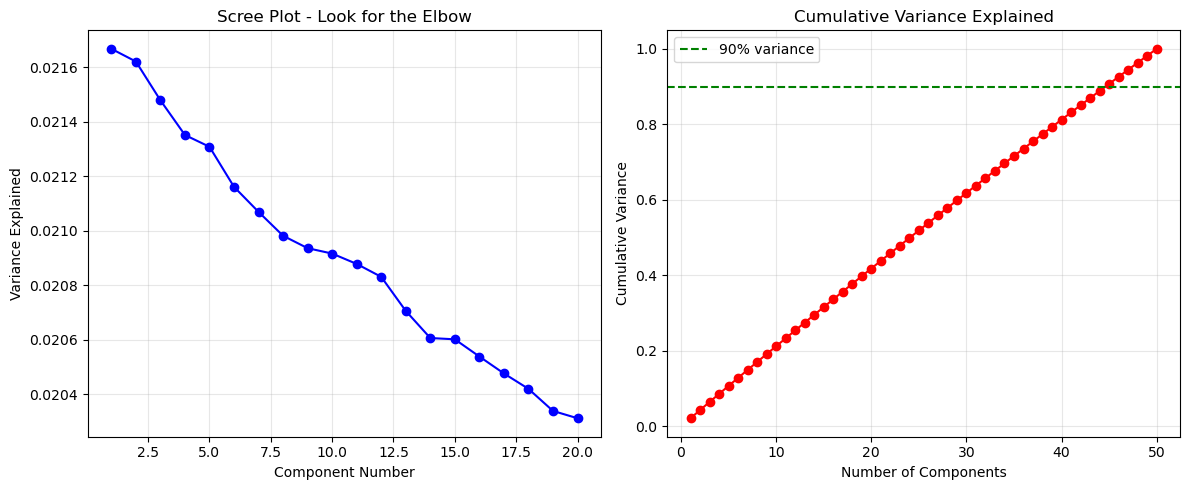

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scree Plot
ax1.plot(range(1, 21), pca_full.explained_variance_ratio_[:20], 'bo-')
ax1.set(xlabel='Component Number', ylabel='Variance Explained', title='Scree Plot - Look for the Elbow')
ax1.grid(True, alpha=0.3)

# Cumulative Variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
ax2.plot(range(1, 51), cumulative_variance, 'ro-')
ax2.axhline(y=0.90, color='green', linestyle='--', label='90% variance')
ax2.set(xlabel='Number of Components', ylabel='Cumulative Variance', title='Cumulative Variance Explained')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



**Scree Plot Observation**

The scree plot shows a **gradual, continuous decline** without a clear elbow point. The variance explained decreases smoothly from component to component, making it difficult to identify an obvious cutoff point using the elbow method.

**Cumulative Variance Observation**

The cumulative variance plot displays an **almost linear increase**, indicating that each component contributes relatively equally to the total variance.

**Component Selection Decision**

Given the absence of a clear elbow and the linear variance accumulation, we use the **90% variance threshold** as our selection criterion. 90% is a widely accepted benchmark for retaining sufficient information

In [53]:
n_components = np.argmax(cumulative_variance >= 0.90) + 1

print(f"Components needed for 90% variance: {n_components}")
print(f"Variance retained: {cumulative_variance[n_components-1]*100:.1f}%")
print(f"Dimensionality reduction: {X_anonymous.shape[1]} → {n_components} features")

# Transform data
pca = PCA(n_components=n_components, random_state=SEED)
X_pca = pca.fit_transform(X_anonymous)
pca_columns = [f'PCA_{i+1}' for i in range(n_components)]

Components needed for 90% variance: 45
Variance retained: 90.7%
Dimensionality reduction: 50 → 45 features


#### 4.1.3  Add PCA Components

In [54]:
df_engineered = df_engineered.drop(columns=anonymous_features)
df_engineered[pca_columns] = X_pca

print(f"df_engineered updated: {df_engineered.shape}")

df_engineered updated: (189794, 57)


### 4.2 Spending Rate: Average spending per transaction

In [55]:
df_engineered['SpendingRate'] = df_engineered['TotalSpend'] / (df_engineered['TotalTransactions'])

### 4.3 Monthly Spending Rate: Average monthly spending

In [56]:
df_engineered['MonthlySpendingRate'] = df_engineered['TotalSpend'] / ((df_engineered['Tenure'] * 12))

### 4.4 Transaction Frequency: Average transactions per month of tenure

In [57]:
df_engineered['TransactionFrequency'] = df_engineered['TotalTransactions'] / ((df_engineered['Tenure'] * 12))

### 4.5 Tenure Groups: Customer loyalty segments

In [58]:
print(f"Tenure min: {df_engineered['Tenure'].min()}")
print(f"Tenure max: {df_engineered['Tenure'].max()}")

Tenure min: 1
Tenure max: 19


In [59]:
df_engineered['TenureGroup'] = pd.cut(df_engineered['Tenure'], bins=[0, 3, 6, 12, 20], labels=['New', 'Growing', 'Established', 'Loyal'])

### 4.6 Credit Limit Tier: Categorize credit limits

In [60]:
df_engineered['CreditTier'] = pd.qcut(df_engineered['CreditLimit'], q=4, labels=['Low', 'Medium', 'High', 'Premium'])

### 4.7 Log Transformation

In [61]:
# Features to check for log transformation
numerical_features_for_transform = ['Age', 'Income', 'CreditLimit', 'TotalTransactions', 'TotalSpend', 'Tenure', 'SpendingRate', 'MonthlySpendingRate', 'TransactionFrequency']

# Check skewness and determine log transform candidates
features_to_check = [f for f in numerical_features_for_transform if f in df_engineered.columns]

skewness_df = pd.DataFrame({
    'Feature': features_to_check,
    'Skewness': [df_engineered[col].skew() for col in features_to_check],
    'Min_Value': [df_engineered[col].min() for col in features_to_check]
})

# Determine which features need log transform (skewed and positive)
skewness_df['Apply_Log'] = (abs(skewness_df['Skewness']) > 1.0) & (skewness_df['Min_Value'] > 0)
skewness_df = skewness_df.sort_values('Skewness', key=abs, ascending=False)

display(skewness_df)
features_to_log = skewness_df[skewness_df['Apply_Log']]['Feature'].tolist()
print(f"\nFeatures to log-transform ({len(features_to_log)}): {features_to_log}")

,Feature,Skewness,Min_Value,Apply_Log
1,Income,10.317593,-18277.719329,False
7,MonthlySpendingRate,7.618697,-159.057085,False
4,TotalSpend,5.234408,-4005.132671,False
6,SpendingRate,5.208767,-44.501474,False
8,TransactionFrequency,3.103723,0.285088,True
3,TotalTransactions,0.123237,61.000000,False
2,CreditLimit,0.041732,12.273649,False
5,Tenure,0.039382,1.000000,False
0,Age,0.011689,7.000000,False



Features to log-transform (1): ['TransactionFrequency']


#### 4.7.1 Log Transform `TransactionFrequency`

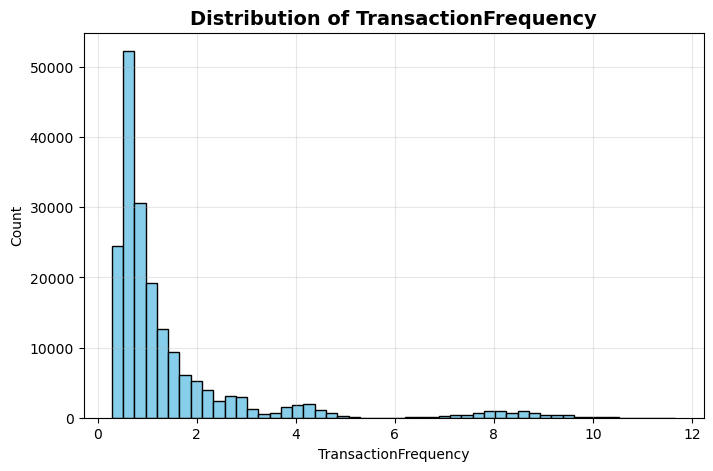

In [62]:
plt.figure(figsize=(8, 5))
plt.hist(df_engineered['TransactionFrequency'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of TransactionFrequency', fontsize=14, fontweight='bold')
plt.xlabel('TransactionFrequency')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

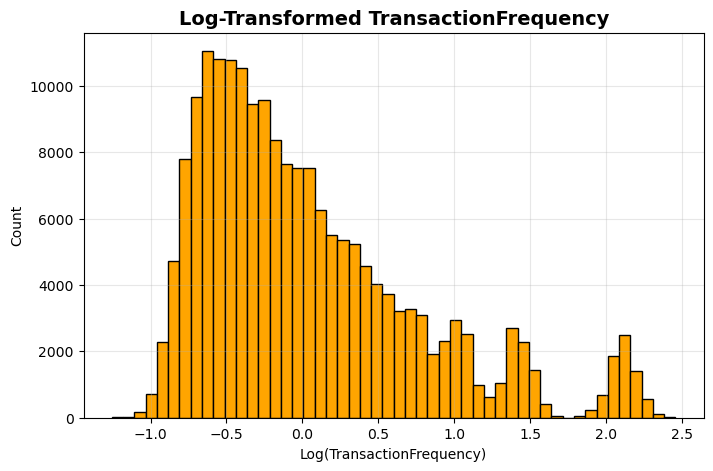

In [63]:
df_engineered['Log_TransactionFrequency'] = np.log(df_engineered['TransactionFrequency'])
df_engineered = df_engineered.drop(columns=['TransactionFrequency'])

plt.figure(figsize=(8, 5))
plt.hist(df_engineered['Log_TransactionFrequency'].dropna(), bins=50, color='orange', edgecolor='black')
plt.title('Log-Transformed TransactionFrequency', fontsize=14, fontweight='bold')
plt.xlabel('Log(TransactionFrequency)')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

### 4.8 LabelEncoder

In [64]:
# Identify nominal categorical features (no inherent order)
nominal_features = ['Gender', 'MaritalStatus', 'EducationLevel']

In [65]:
for col in nominal_features:
    if col in df_engineered.columns:
        le = LabelEncoder()
        df_engineered[f'{col}_encoded'] = le.fit_transform(df_engineered[col])
        df_engineered = df_engineered.drop(columns=[col])
        print(f"LabelEncoder applied to {col}")

LabelEncoder applied to Gender
LabelEncoder applied to MaritalStatus
LabelEncoder applied to EducationLevel


### 4.9 OrdinalEncoder

In [66]:
print(f"Card Type: {df_engineered['CardType'].unique()}")
print(f"Tenure Group: {df_engineered['TenureGroup'].unique()}")
print(f"Credit Tier: {df_engineered['CreditTier'].unique()}")

Card Type: ['Platinum' 'Gold' 'Silver' 'Black']
Tenure Group: ['New', 'Established', 'Loyal', 'Growing']
Categories (4, object): ['New' < 'Growing' < 'Established' < 'Loyal']
Credit Tier: ['High', 'Low', 'Medium', 'Premium']
Categories (4, object): ['Low' < 'Medium' < 'High' < 'Premium']


In [67]:
ordinal_mappings = {
    'CardType': ['Silver', 'Gold', 'Platinum', 'Black'],
    'TenureGroup': ['New', 'Growing', 'Established', 'Loyal'],
    'CreditTier': ['Low', 'Medium', 'High', 'Premium']
}

In [68]:
for col, order in ordinal_mappings.items():
    if col in df_engineered.columns:
        # Apply encoding
        oe = OrdinalEncoder(categories=[order])
        df_engineered[f'{col}_ordinal'] = oe.fit_transform(df_engineered[[col]])

        # Display mapping
        mapping = {val: i for i, val in enumerate(order)}
        print(f"\n{col} → {col}_ordinal:")
        for val, num in mapping.items():
            print(f"  {val} = {num}")

        # Drop original column
        df_engineered.drop(columns=[col], inplace=True)


CardType → CardType_ordinal:
  Silver = 0
  Gold = 1
  Platinum = 2
  Black = 3

TenureGroup → TenureGroup_ordinal:
  New = 0
  Growing = 1
  Established = 2
  Loyal = 3

CreditTier → CreditTier_ordinal:
  Low = 0
  Medium = 1
  High = 2
  Premium = 3


### 4.10 Summary

In [69]:
# Calculate feature counts
original_cols = set(df_clean.columns)
final_cols = set(df_engineered.columns)
removed = original_cols - final_cols
added = final_cols - original_cols

# Display summary
display(Markdown(f"""
**FEATURE ENGINEERING SUMMARY**

**Dataset Comparison:**
- **Before (df_clean):** {len(original_cols)} features
- **After (df_engineered):** {len(final_cols)} features
- **Net change:** {len(final_cols) - len(original_cols):+d} features

**Removed Features ({len(removed)} total):**
- 50 anonymous features (Feature_0 to Feature_49)
- 5 categorical features (Gender, MaritalStatus, EducationLevel, CardType, Country)

**Added Features ({len(added)} total):**
- 45 PCA components (replacing anonymous features)
- 3 encoded categoricals (Gender_encoded, MaritalStatus_encoded, EducationLevel_encoded)
- 3 ordinal features (CardType_ordinal, TenureGroup_ordinal, CreditTier_ordinal)
- 3 ratio features (SpendingRate, MonthlySpendingRate, TransactionFrequency)
- 1 log-transformed feature (Log_TransactionFrequency)
"""))


**FEATURE ENGINEERING SUMMARY**

**Dataset Comparison:**
- **Before (df_clean):** 62 features
- **After (df_engineered):** 62 features
- **Net change:** +0 features

**Removed Features (54 total):**
- 50 anonymous features (Feature_0 to Feature_49)
- 5 categorical features (Gender, MaritalStatus, EducationLevel, CardType, Country)

**Added Features (54 total):**
- 45 PCA components (replacing anonymous features)
- 3 encoded categoricals (Gender_encoded, MaritalStatus_encoded, EducationLevel_encoded)
- 3 ordinal features (CardType_ordinal, TenureGroup_ordinal, CreditTier_ordinal)
- 3 ratio features (SpendingRate, MonthlySpendingRate, TransactionFrequency)
- 1 log-transformed feature (Log_TransactionFrequency)


# 5. Final Dataset Preparation

In [70]:
df_final = df_engineered.copy()
print(f"Starting with {df_final.shape[1]} features and {df_final.shape[0]} samples")

Starting with 62 features and 189794 samples


In [71]:
df_final.head()

,Age,Income,CreditLimit,TotalTransactions,TotalSpend,Tenure,AttritionFlag,CustomerID,PCA_1,PCA_2,...,PCA_45,SpendingRate,MonthlySpendingRate,Log_TransactionFrequency,Gender_encoded,MaritalStatus_encoded,EducationLevel_encoded,CardType_ordinal,TenureGroup_ordinal,CreditTier_ordinal
0,45,112955.763499,18089.293599,102,7057.961760,3,0,CUST047573,-0.627716,-0.548385,...,0.208722,69.195704,196.054493,1.041454,0,0,2,2.0,0.0,2.0
1,44,42980.787139,17317.747673,94,8101.572278,9,0,CUST006615,0.304186,-0.499515,...,-3.002816,86.186939,75.014558,-0.138836,0,0,3,1.0,2.0,2.0
2,44,114584.549890,17450.444657,87,17989.977994,16,0,CUST032313,0.093763,-1.512860,...,-1.112009,206.781356,93.697802,-0.791587,1,0,0,0.0,3.0,2.0
3,40,76207.866249,10444.914691,90,2534.813451,11,0,CUST008756,0.014215,-1.669439,...,-0.821065,28.164594,19.203132,-0.382992,0,1,2,1.0,2.0,0.0
4,47,74041.286720,8022.710937,106,6290.093235,4,0,CUST043700,-0.917473,-1.225037,...,-0.380129,59.340502,131.043609,0.792238,1,2,3,2.0,1.0,0.0


In [ ]:
os.makedirs('datasets', exist_ok=True)
df_final.to_csv("datasets/final_cc_attrition.csv", index=False)

In [72]:
X = df_final.drop(columns=['AttritionFlag', 'CustomerID'])
y = df_final['AttritionFlag']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")

Features shape: (189794, 60)
Target shape: (189794,)
Number of features: 60


In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print(f"Training set shape: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Test set shape: X_test = {X_test.shape}, y_test = {y_test.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print(f"\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set shape: X_train = (151835, 60), y_train = (151835,)
Test set shape: X_test = (37959, 60), y_test = (37959,)

Class distribution in training set:
AttritionFlag
1    0.500003
0    0.499997
Name: proportion, dtype: float64

Class distribution in test set:
AttritionFlag
0    0.500013
1    0.499987
Name: proportion, dtype: float64


**Model Selection: Tree-Based Ensemble Methods**

**Why No Standardization?**

Tree-based models (LightGBM, XGBoost) make splits based on value thresholds, not distances. They only care about the relative ordering of values, not their scale.

**Why Tree-Based Models?**

**1. Low Feature Correlations**
- Our analysis shows correlations between variables are nearly 0
- Tree-based models excel with independent features as they can capture non-linear patterns without multicollinearity issues

**2. High Dimensional Data Without Feature Selection**
- We have 60+ features after engineering (including 45 PCA components)
- Tree-based models automatically perform implicit feature selection through splitting
- No need for manual feature selection - the models naturally use only informative features
- Can handle hundreds of features without overfitting through ensemble averaging

**3. Feature Importance**
- These models provide clear feature importance scores
- Helps identify which factors drive customer attrition for business insights

**4. Robust to Outliers**
- Unlike linear models, tree-based methods are not sensitive to outliers
- Important for financial data which often has extreme values that we can't remove

**Selected Models:**
- **LightGBM**: Fast training, memory efficient, handles large datasets well
- **XGBoost**: Often best performance, extensive hyperparameter tuning options

# 6. Model Development

> Our main metric is `Recall`

Why? missing a churner (False Negative) is expensive:

- You lose the customer permanently
- No chance for intervention
- High replacement cost

### 6.1 Hyperparameter Grids
- [LightGBM Hyperparameter Reference](https://medium.com/@cyrilladrian.wicaksono/credit-risk-prediction-with-hyperparameter-tuning-2f141912150a)
- [XGBoost Hyperparameter Reference](https://medium.com/@zargi.teddy7/credit-card-fraud-detection-using-xgboost-classifier-and-gridsearchcv-hyperparameter-tuning-631c0632e9e9)

In [74]:
param_lgbm = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63],
    'feature_fraction': [0.6, 0.8, 1.0],
    'bagging_fraction': [0.6, 0.8, 1.0],
}

param_xgb= {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

### 6.2 Train LightGBM Classifier

In [75]:
lgbm_model = lgb.LGBMClassifier(
    random_state=SEED,
    n_jobs=-1,
    verbosity=-1,
    force_col_wise=True
)

lgbm_grid = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_lgbm,
    n_iter=200,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=2,
    random_state=SEED
)

# Train the model
lgbm_grid.fit(X_train, y_train)

print(f"\nBest LightGBM parameters: {lgbm_grid.best_params_}")
print(f"Best cross-validation recall score: {lgbm_grid.best_score_:.4f}")

# Get the best model
lgbm_best = lgbm_grid.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits

Best LightGBM parameters: {'num_leaves': 63, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
Best cross-validation recall score: 0.9527


### 6.3 Train XGBoost Classifier

In [76]:
xgb_model = xgb.XGBClassifier(
    random_state=SEED,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_grid = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_xgb,
    n_iter=200,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=2,
    random_state=SEED
)

# Train the model
xgb_grid.fit(X_train, y_train)

print(f"\nBest XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best cross-validation recall score: {xgb_grid.best_score_:.4f}")

# Get the best model
xgb_best = xgb_grid.best_estimator_

c:\Users\dariu\anaconda3\envs\nn-gpu\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 108 is smaller than n_iter=200. Running 108 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\dariu\anaconda3\envs\nn-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [19:07:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best XGBoost parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best cross-validation recall score: 0.9257


# 7. Model Evaluation

### 7.1 Function to evaluate model performance

In [77]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a model and return performance metrics
    """
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Confusion_Matrix': cm
    }

### 7.2 Save and Load Models

In [78]:
os.makedirs('models', exist_ok=True)

joblib.dump(lgbm_best, 'models/lightgbm_best.pkl')
joblib.dump(xgb_best, 'models/xgboost_best.pkl')

models = {
    'LightGBM': lgbm_best,
    'XGBoost': xgb_best
}

joblib.dump(models, 'models/all_models.pkl')

# Also save the best parameters for reference
best_params = {
    'LightGBM': lgbm_grid.best_params_,
    'XGBoost': xgb_grid.best_params_
}
joblib.dump(best_params, 'models/best_parameters.pkl')

print("Models saved successfully!")
print(f"Location: ./models/")

Models saved successfully!
Location: ./models/


In [79]:
lgbm_loaded = joblib.load('models/lightgbm_best.pkl')
xgb_loaded = joblib.load('models/xgboost_best.pkl')

models_loaded = joblib.load('models/all_models.pkl')
best_params_loaded = joblib.load('models/best_parameters.pkl')

# Verify models are loaded
print("Models loaded successfully!")
for name, model in models_loaded.items():
    print(f"- {name}: {type(model).__name__}")

Models loaded successfully!
- LightGBM: LGBMClassifier
- XGBoost: XGBClassifier


### 7.3 Evaluate all Models

In [80]:
results = []
for name, model in models.items():
    result = evaluate_model(model, X_test, y_test, name)
    results.append(result)
    print(f"{name} evaluated!")

LightGBM evaluated!
XGBoost evaluated!


In [81]:
# Create comparison dataframe
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.drop('Confusion_Matrix', axis=1)

# Format and sort
comparison_df = comparison_df.round(4)
comparison_df = comparison_df.sort_values('Recall', ascending=False)

### 7.4 Display Results

In [82]:
display(comparison_df)

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_recall = comparison_df.iloc[0]['Recall']
best_precision = comparison_df.iloc[0]['Precision']

display(Markdown(f"""
**Best Model: {best_model_name}**
- Recall: {best_recall:.2%} (catches {best_recall:.0%} of churners)
- Precision: {best_precision:.2%}

**Conclusion:** Using {best_model_name} for maximum credit card attrition detection
"""))

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,LightGBM,0.9272,0.9037,0.9564,0.9293,0.9791
1,XGBoost,0.8946,0.8688,0.9295,0.8981,0.9611



**Best Model: LightGBM**
- Recall: 95.64% (catches 96% of churners)
- Precision: 90.37%

**Conclusion:** Using LightGBM for maximum credit card attrition detection


### 7.5 Confusion Matrices

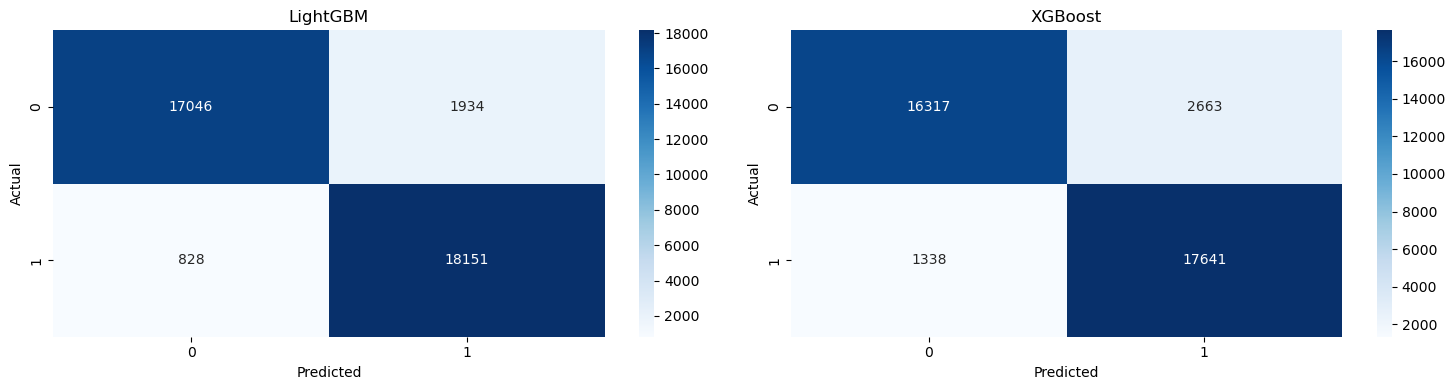


**LightGBM Confusion Matrix Details:**
- True Negatives: 17,046 (correctly identified non-churners)
- False Positives: 1,934 (false alarms)
- False Negatives: 828 (missed churners)
- True Positives: 18,151 (correctly identified churners)


In [85]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

for idx, result in enumerate(results):
    cm = result['Confusion_Matrix']
    model_name = result['Model']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{model_name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Show confusion matrix for best model with details
best_model_cm = next(r['Confusion_Matrix'] for r in results if r['Model'] == best_model_name)
tn, fp, fn, tp = best_model_cm.ravel()

display(Markdown(f"""
**{best_model_name} Confusion Matrix Details:**
- True Negatives: {tn:,} (correctly identified non-churners)
- False Positives: {fp:,} (false alarms)
- False Negatives: {fn:,} (missed churners)
- True Positives: {tp:,} (correctly identified churners)
"""))

# 8. Insights & Recommendations

### 8.1 Feature Importance from LightGBM

In [89]:
# Get feature importance from LightGBM
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbm_best.feature_importances_
}).sort_values('Importance', ascending=False)

# Calculate percentage contribution
feature_importance['Percentage'] = (feature_importance['Importance'] / 
                                   feature_importance['Importance'].sum() * 100).round(2)

# Get top 10 features
top_10 = feature_importance.head(10).reset_index(drop=True)

# Display results
display(Markdown("**Top 10 Most Important Features**"))
display(top_10)

**Top 10 Most Important Features**

,Feature,Importance,Percentage
0,Income,1413,4.57
1,CreditLimit,1204,3.90
2,TotalSpend,708,2.29
3,PCA_36,629,2.04
4,PCA_21,621,2.01
5,PCA_39,613,1.98
6,PCA_40,611,1.98
7,PCA_41,611,1.98
8,PCA_32,609,1.97
9,PCA_45,608,1.97


#### 8.1.1 Bar Chart for the Important Features

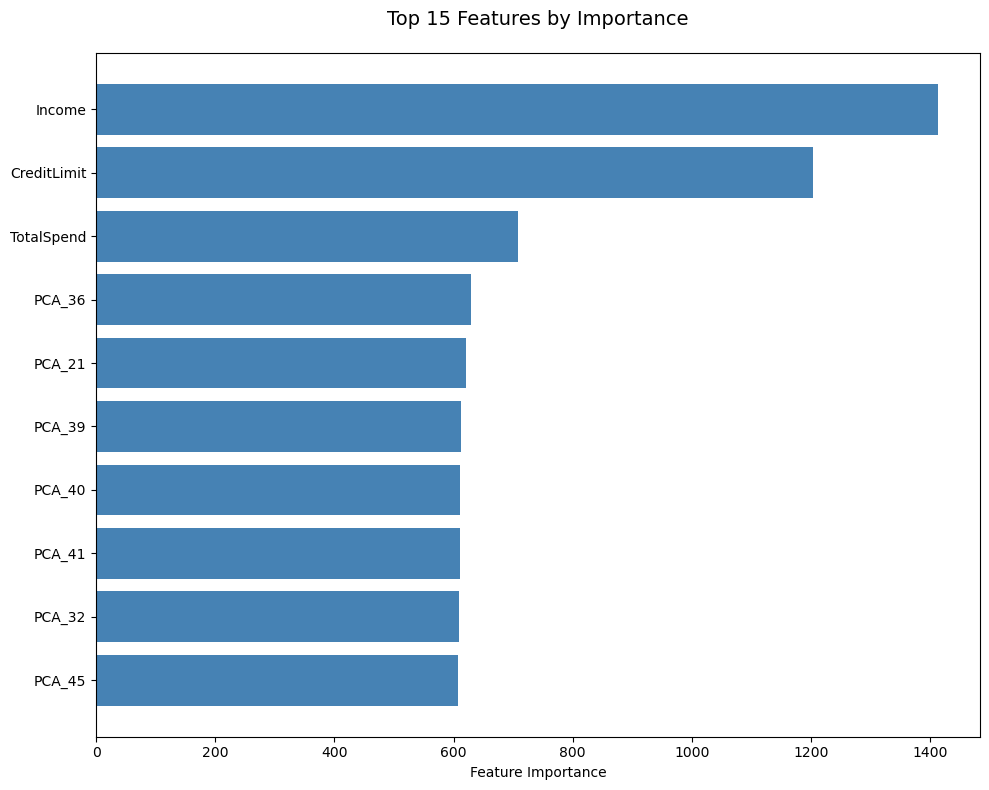

In [90]:
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_10)), top_10['Importance'], color='steelblue')
plt.yticks(range(len(top_10)), top_10['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features by Importance', fontsize=14, pad=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The analysis reveals that **credit card attrition is primarily driven by three financial factors**:

1. **Income** - Customer's annual income
2. **Credit Limit** - Maximum credit available on the card  
3. **Total Spend** - Customer's total spending amount

These three features alone contribute most of the model's predictive power, indicating that financial behavior and capacity are the strongest indicators of whether a customer will close their credit card account.

**What This Means**

> Financial Profile Matters Most

- **Higher income customers** tend to have different attrition patterns, possibly due to having more options or different expectations
- **Credit limit** reflects the bank's assessment of customer creditworthiness and their relationship value
- **Spending patterns** directly show customer engagement with the credit card


**Customers who are likely to leave typically show:**

- Mismatch between their income level and credit limit offered
- Changes in spending behavior over time
- Lower overall transaction amounts compared to their credit limit

#### 8.1.2 Cumulative Importance

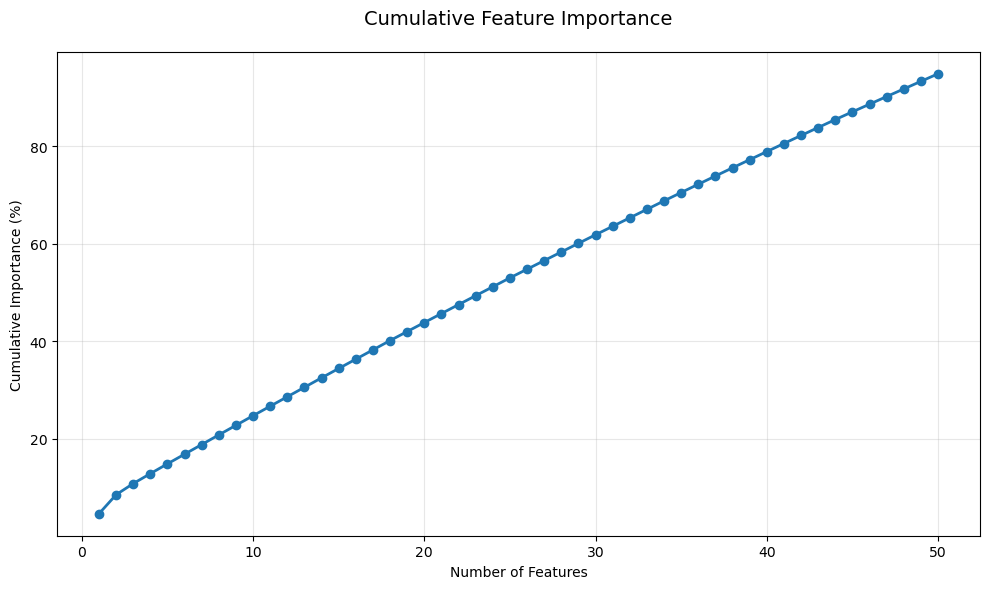

In [97]:
feature_importance['Cumulative'] = feature_importance['Percentage'].cumsum()

# Plot cumulative importance
plt.figure(figsize=(10, 6))
x_range = range(1, min(51, len(feature_importance) + 1))
cumulative_values = feature_importance['Cumulative'].iloc[:50]

plt.plot(x_range, cumulative_values, marker='o', linewidth=2, markersize=6)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance (%)')
plt.title('Cumulative Feature Importance', fontsize=14, pad=20)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The **linear trend** in cumulative importance indicates that:

- Each additional feature contributes roughly equal incremental value
- There's no clear "elbow point" where adding more features stops being useful
- The model benefits from the full feature set rather than just a few dominant variables

This linear pattern suggests that while Income, CreditLimit, and TotalSpend are the top contributors, **the remaining features collectively add significant predictive value through capturing different aspects of customer behavior.

**Recommendations Based on these findings:**

1. **Focus retention efforts** on customers showing unusual patterns in income-to-credit-limit ratios
2. **Monitor spending trends** as early warning signals for potential attrition
3. **Consider all features** when building predictive models, as the linear cumulative pattern shows each adds value
4. **Develop targeted strategies** for different financial segments based on income and credit limit combinations

### 8.2 Other Data-Driven Recommendations

#### 8.2.1 Customer Tenure Analysis

In [108]:
tenure_mapping = {0: 'New (0-3 yrs)', 1: 'Growing (3-6 yrs)', 
                    2: 'Established (6-12 yrs)', 3: 'Loyal (12+ yrs)'}
tenure_analysis = df_final.groupby('TenureGroup_ordinal')['AttritionFlag'].agg([
    ('Customers', 'count'),
    ('Attrition Rate (%)', lambda x: round(x.mean() * 100, 1))
])
tenure_analysis.index = tenure_analysis.index.map(tenure_mapping)

# Calculate rates by ordinal value
new_rate = df_final[df_final['TenureGroup_ordinal'] == 0]['AttritionFlag'].mean() * 100
growing_rate = df_final[df_final['TenureGroup_ordinal'] == 1]['AttritionFlag'].mean() * 100
established_rate = df_final[df_final['TenureGroup_ordinal'] == 2]['AttritionFlag'].mean() * 100
loyal_rate = df_final[df_final['TenureGroup_ordinal'] == 3]['AttritionFlag'].mean() * 100

display(tenure_analysis)

,Customers,Attrition Rate (%)
TenureGroup_ordinal,,
New (0-3 yrs),25546,42.1
Growing (3-6 yrs),32474,53.6
Established (6-12 yrs),69663,56.9
Loyal (12+ yrs),62111,43.7


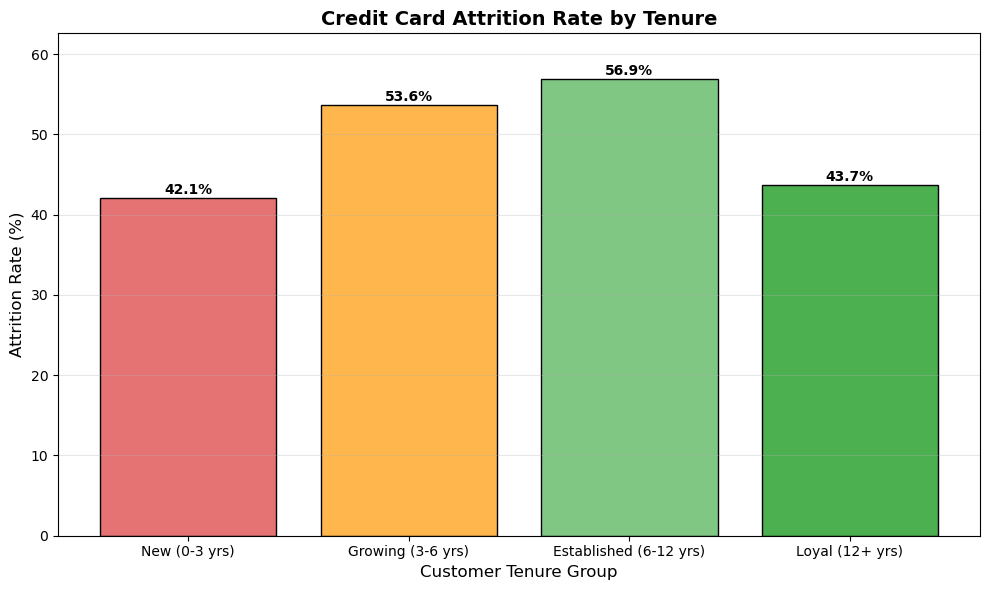

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(range(len(tenure_analysis)), 
               tenure_analysis['Attrition Rate (%)'],
               color=['#E57373', '#FFB74D', '#81C784', '#4CAF50'],
               edgecolor='black', linewidth=1)

ax.set_xlabel('Customer Tenure Group', fontsize=12)
ax.set_ylabel('Attrition Rate (%)', fontsize=12)
ax.set_title('Credit Card Attrition Rate by Tenure', fontsize=14, fontweight='bold')

ax.set_xticks(range(len(tenure_analysis)))
ax.set_xticklabels(tenure_analysis.index, fontsize=10)

# Add value labels on top of bars
for i, (idx, row) in enumerate(tenure_analysis.iterrows()):
    ax.text(i, row['Attrition Rate (%)'] + 0.5, 
            f"{row['Attrition Rate (%)']}%", 
            ha='center', fontweight='bold')

# Add grid
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, tenure_analysis['Attrition Rate (%)'].max() * 1.1)

plt.tight_layout()
plt.show()

In [114]:
display(Markdown(f"""
**Key Insight**
                 
- **New (0-3 years):** {new_rate:.1f}% attrition
- **Growing (3-6 years):** {growing_rate:.1f}% attrition  
- **Established (6-12 years):** {established_rate:.1f}% attrition
- **Loyal (12+ years):** {loyal_rate:.1f}% attrition

**Risk Pattern:** {
'Highest risk in Growing phase' if growing_rate == max(new_rate, growing_rate, established_rate, loyal_rate) else
'Highest risk in New phase' if new_rate == max(new_rate, growing_rate, established_rate, loyal_rate) else
'Highest risk in Established phase' if established_rate == max(new_rate, growing_rate, established_rate, loyal_rate) else
'Highest risk in Loyal phase'
} ({max(new_rate, growing_rate, established_rate, loyal_rate):.1f}%)
"""))


**Key Insight**
                 
- **New (0-3 years):** 42.1% attrition
- **Growing (3-6 years):** 53.6% attrition  
- **Established (6-12 years):** 56.9% attrition
- **Loyal (12+ years):** 43.7% attrition

**Risk Pattern:** Highest risk in Established phase (56.9%)


**Immediate Actions:**
- **Milestone Rewards** - Special benefits at 6, 9, and 12-year anniversaries
- **Re-engagement Campaign** - Personalized offers for 6-12 year customers showing reduced activity

**Why it will work:** Customers in the 6-12 year range have likely paid off initial purchases/debts and are reassessing their card portfolio. Intervention before year 6 is critical.

#### 8.2.2 Card Type Analysis

In [110]:
card_mapping = {0: 'Silver', 1: 'Gold', 2: 'Platinum', 3: 'Black'}

card_analysis = df_final.groupby('CardType_ordinal')['AttritionFlag'].agg([
    ('Customers', 'count'),
    ('Attrition Rate (%)', lambda x: round(x.mean() * 100, 1))
])
card_analysis.index = card_analysis.index.map(card_mapping)

display(card_analysis)

,Customers,Attrition Rate (%)
CardType_ordinal,,
Silver,45760,48.4
Gold,45356,47.6
Platinum,48328,50.8
Black,50350,52.8


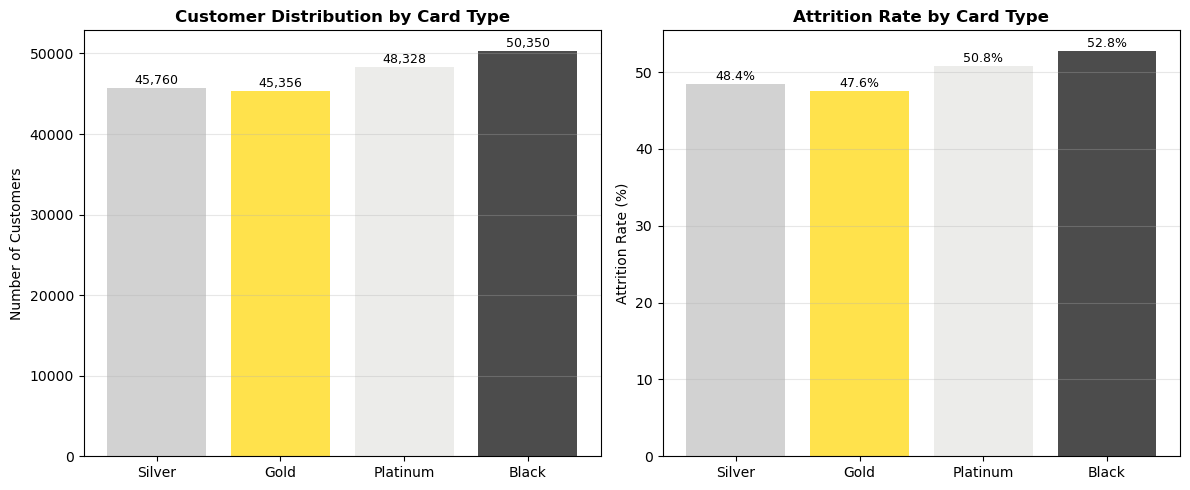

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Customer distribution by card type
ax1 = axes[0]
card_counts = card_analysis['Customers']
colors = ['#C0C0C0', '#FFD700', '#E5E4E2', '#000000']  # Silver, Gold, Platinum, Black
bars1 = ax1.bar(range(len(card_counts)), card_counts.values, color=colors[:len(card_counts)], alpha=0.7)
ax1.set_xticks(range(len(card_counts)))
ax1.set_xticklabels(card_counts.index, rotation=0)
ax1.set_title('Customer Distribution by Card Type', fontweight='bold')
ax1.set_ylabel('Number of Customers')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars1, card_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + card_counts.max()*0.01,
             f'{val:,}', ha='center', fontsize=9)

# Attrition rate by card type
ax2 = axes[1]
attrition_rates = card_analysis['Attrition Rate (%)']
bars2 = ax2.bar(range(len(attrition_rates)), attrition_rates.values, color=colors[:len(attrition_rates)], alpha=0.7)
ax2.set_xticks(range(len(attrition_rates)))
ax2.set_xticklabels(attrition_rates.index, rotation=0)
ax2.set_title('Attrition Rate by Card Type', fontweight='bold')
ax2.set_ylabel('Attrition Rate (%)')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars2, attrition_rates.values):
    ax2.text(bar.get_x() + bar.get_width()/2, val + attrition_rates.max()*0.01,
             f'{val:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [115]:
basic_cards_risk = df_final[df_final['CardType_ordinal'].isin([0, 1])]['AttritionFlag'].mean() * 100  # Silver & Gold
premium_cards_risk = df_final[df_final['CardType_ordinal'].isin([2, 3])]['AttritionFlag'].mean() * 100  # Platinum & Black

display(Markdown(f"""
**Key Insight**
                 
- **Basic cards (Silver/Gold):** {basic_cards_risk:.1f}% attrition
- **Premium cards (Platinum/Black):** {premium_cards_risk:.1f}% attrition

*Premium card holders show {'higher' if premium_cards_risk > basic_cards_risk else 'lower'} attrition - {'they may have more alternatives and higher expectations' if premium_cards_risk > basic_cards_risk else 'they likely receive better benefits and service'}.*
"""))


**Key Insight**
                 
- **Basic cards (Silver/Gold):** 48.0% attrition
- **Premium cards (Platinum/Black):** 51.8% attrition

*Premium card holders show higher attrition - they may have more alternatives and higher expectations.*


**Immediate Actions:**
- **Premium Perks Audit** - Survey Black/Platinum holders about unmet expectations
- **Exclusive Experiences** - Add unique benefits competitors can't match (concert access, concierge upgrades)

**Why it will work:** Premium customers have more options and higher expectations. They're leaving because the premium doesn't feel premium enough compared to competitors.